## Basic routine to create sawtooth data

In [178]:
t = np.arange(0,100,0.8)
p=5
y = 1/2 * p * t % (2 * p)
y

array([0., 2., 4., 6., 8., 0., 2., 4., 6., 8., 0., 2., 4., 6., 8., 0., 2.,
       4., 6., 8., 0., 2., 4., 6., 8., 0., 2., 4., 6., 8., 0., 2., 4., 6.,
       8., 0., 2., 4., 6., 8., 0., 2., 4., 6., 8., 0., 2., 4., 6., 8., 0.,
       2., 4., 6., 8., 0., 2., 4., 6., 8., 0., 2., 4., 6., 8., 0., 2., 4.,
       6., 8., 0., 2., 4., 6., 8., 0., 2., 4., 6., 8., 0., 2., 4., 6., 8.,
       0., 2., 4., 6., 8., 0., 2., 4., 6., 8., 0., 2., 4., 6., 8., 0., 2.,
       4., 6., 8., 0., 2., 4., 6., 8., 0., 2., 4., 6., 8., 0., 2., 4., 6.,
       8., 0., 2., 4., 6., 8.])

## Create data

In [1]:
from numpy import *
from matplotlib.pyplot import *
import scipy.linalg
import matplotlib.pyplot as plt

In [2]:
def getData(size=5100, numChanges = 20):
    #maxchanges = 50
    #numChanges = random.randint(10, maxchanges)
    #numChanges = 10
    t = np.arange(0,size*0.8,0.8)
    rlist = list()
    while numChanges:
        r = random.randint(1,size)
        if r not in rlist:
            rlist.append(r)
        numChanges -= 1
    rlist.sort()

    for i in range(len(t)):
        if i in rlist:
            for j in range(i, len(t)):
                t[j] = -t[j]

    p=5
    data = 1/2 * p * t % (2 * p)
    
    y1 = list()
    y2 = list()
    for i in range(len(t)):
        if t[i] < 0:
            y1.append(1)
            y2.append(0)
        else:
            y1.append(0)
            y2.append(1)
            
    return data, y1, y2

## Plot some data

In [3]:
data, y1, y2 = getData()

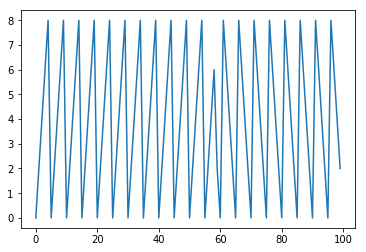

In [4]:
plt.plot(data[0:100])
plt.show()

## Plot desired output

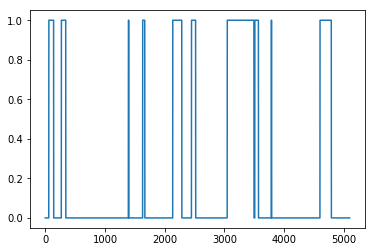

In [5]:
plt.plot(y1)
plt.show()

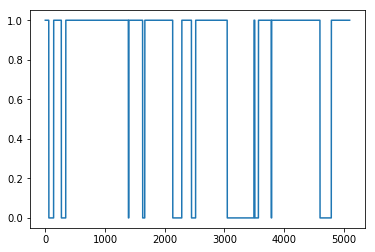

In [6]:
plt.plot(y2)
plt.show()

In [7]:
len(data)

5100

# ESN

In [8]:
initLen = 100
trainLen = 2500
testLen = 2500

In [9]:
# generate ESN reservoir
inSize = 1
outSize = 2
resSize = 300
a = 1 # leaking rate
random.seed(42)

Win = random.rand(resSize,1+inSize)-0.5 # should have positive and negative values
W = random.rand(resSize,resSize)-0.5

# normalizing and setting spectral radius (correct, slow):
rhoW = max(abs(linalg.eig(W)[0]))
W *= 1 / rhoW

In [10]:
# allocated memory for the design (collected states) matrix
X = zeros((1+inSize+resSize,trainLen-initLen))
# set the corresponding target matrix directly
Yt = [y1[initLen+1:trainLen+1], y2[initLen+1:trainLen+1]]

## set input and internal weights

In [11]:
# run the reservoir with the data and collect X
x = zeros((resSize,1))
for t in range(trainLen):
    u = data[t]
    x = (1-a)*x + a*tanh( dot( Win, vstack((1,u)) ) + dot( W, x ) )
    if t >= initLen:
        X[:,t-initLen] = vstack((1,u,x))[:,0]

In [12]:
X.shape

(302, 2400)

In [22]:
len(Yt[0])

2400

##  Train output weights

In [274]:
# train the output by ridge regression
reg = 1e-2  # regularization coefficient
X_T = X.T
Wout = dot( dot(Yt,X_T), linalg.inv( dot(X,X_T) + \
    reg*eye(1+inSize+resSize) ) )

In [275]:
# average absolute size of learned output weights
avgout = sum(abs(Wout))/(len(Wout[0]) * outSize)
print(avgout)

0.11381248094727416


## Run trained ESN & get training error

In [276]:
# run the trained ESN with training data
Y = zeros((outSize,trainLen))
u = data[initLen] # starting point
for t in range(trainLen):
    x = (1-a)*x + a*tanh( dot( Win, vstack((1,u)) ) + dot( W, x ) ) # update internal activations
    y = dot( Wout, vstack((1,u,x)) ) # calculate outputs
    # save the outputs
    Y[:,t][0] = y[0]
    Y[:,t][1] = y[1]
    # get new input
    u = data[initLen+t+1] 

In [277]:
# compute RMSE for the first errorLen time steps
errorLen = trainLen
rmse1 = (sum( square( y1[initLen+1:initLen+errorLen+1] - 
    Y[0,0:errorLen] ) ) / errorLen)**(1/2.0)
print('RMSE = \t' + str( rmse1 ))
nrmse1 = rmse1 / (max(y1) - min(y1))
print('NRMSE = ' + str( nrmse1 ))

RMSE = 	0.06597699910280488
NRMSE = 0.06597699910280488


In [278]:
# compute RMSE for the first errorLen time steps
rmse2 = (sum( square( y2[initLen+1:initLen+errorLen+1] - 
    Y[1,0:errorLen] ) ) / errorLen) **(1/2.0)
print('RMSE = \t' + str( rmse2 ))
nrmse2 = rmse2 / (max(y2) - min(y2))
print('NRMSE = ' + str( nrmse2 ))

RMSE = 	0.06597694400944554
NRMSE = 0.06597694400944554


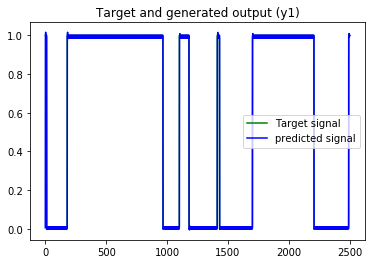

In [279]:
figure(1).clear()
plot( y1[initLen+1:initLen+trainLen+1], 'g' )
plot( Y[0].T, 'b' )
title('Target and generated output (y1)')
legend(['Target signal', 'predicted signal'])
show()

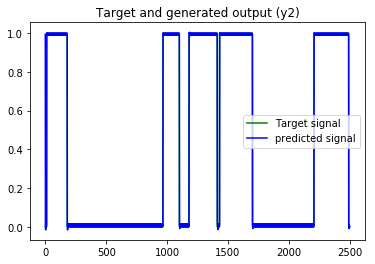

In [280]:
figure(1).clear()
plot( y2[initLen+1:initLen+trainLen+1], 'g' )
plot( Y[1].T, 'b' )
title('Target and generated output (y2)')
legend(['Target signal', 'predicted signal'])
show()

## Test ESN with new data

In [281]:
# run the trained ESN with test data
Y = zeros((outSize,testLen))
u = data[trainLen] # starting point
for t in range(testLen):
    x = (1-a)*x + a*tanh( dot( Win, vstack((1,u)) ) + dot( W, x ) ) # update internal activations
    y = dot( Wout, vstack((1,u,x)) ) # calculate outputs
    # save the outputs
    Y[:,t][0] = y[0]
    Y[:,t][1] = y[1]
    # get new input
    u = data[trainLen+t+1] 

## Test Results

In [282]:
# compute RMSE for the first errorLen time steps
errorLen = testLen
rmse1 = (sum( square( y1[trainLen+1:trainLen+errorLen+1] - 
    Y[0,0:errorLen] ) ) / errorLen)**(1/2.0)
print('RMSE = \t' + str( rmse1 ))
nrmse1 = rmse1 / (max(y1) - min(y1))
print('NRMSE = ' + str( nrmse1 ))

RMSE = 	0.07465069232260087
NRMSE = 0.07465069232260087


In [283]:
# compute RMSE for the first errorLen time steps
rmse2 = (sum( square( y2[trainLen+1:trainLen+errorLen+1] - 
    Y[1,0:errorLen] ) ) / errorLen) **(1/2.0)
print('RMSE = \t' + str( rmse2 ))
nrmse2 = rmse2 / (max(y2) - min(y2))
print('NRMSE = ' + str( nrmse2 ))

RMSE = 	0.07465069707607423
NRMSE = 0.07465069707607423


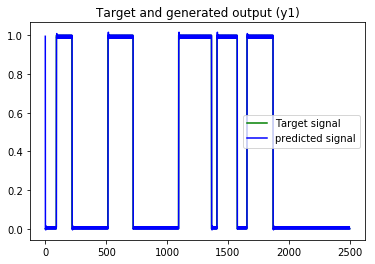

In [284]:
figure(1).clear()
plot( y1[trainLen+1:trainLen+testLen+1], 'g' )
plot( Y[0].T, 'b' )
title('Target and generated output (y1)')
legend(['Target signal', 'predicted signal'])
show()

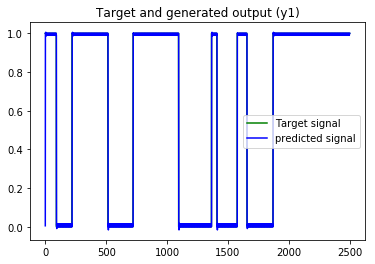

In [285]:
figure(1).clear()
plot( y2[trainLen+1:trainLen+testLen+1], 'g' )
plot( Y[1].T, 'b' )
title('Target and generated output (y1)')
legend(['Target signal', 'predicted signal'])
show()

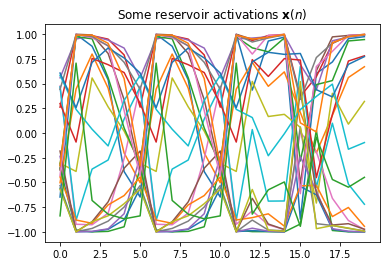

In [286]:
figure(2).clear()
plot( X[2:25,0:20].T )
title('Some reservoir activations $\mathbf{x}(n)$')
show()

In [1240]:
traineval = list()
for times in range(50) :   
    data, y1, y2 = getData(numChanges = 5)
    initLen = 100
    trainLen = 2500
    testLen = 2500

    # generate ESN reservoir
    inSize = 1
    outSize = 2
    resSize = 700
    a = 0.9 # leaking rate
    random.seed(42)

    Win = random.rand(resSize,1+inSize)-0.5
    W = random.rand(resSize,resSize)-0.5 

    # normalizing and setting spectral radius (correct, slow):
    rhoW = max(abs(linalg.eig(W)[0]))
    W *= 1.4 / rhoW

    # allocated memory for the design (collected states) matrix
    X = zeros((1+inSize+resSize,trainLen-initLen))
    # set the corresponding target matrix directly
    Yt = [y1[initLen+1:trainLen+1], y2[initLen+1:trainLen+1]]

    # run the reservoir with the data and collect X
    x = zeros((resSize,1))
    for t in range(trainLen):
        u = data[t]
        x = (1-a)*x + a*tanh( dot( Win, vstack((1,u)) ) + dot( W, x ) )
        if t >= initLen:
            X[:,t-initLen] = vstack((1,u,x))[:,0]

    # train the output by ridge regression
    reg = 1e-4  # regularization coefficient
    X_T = X.T
    Wout = dot( dot(Yt,X_T), linalg.inv( dot(X,X_T) + \
        reg*eye(1+inSize+resSize) ) )

    # average absolute size of learned output weights
    avgout = sum(abs(Wout))/(len(Wout[0]) * outSize)
    #print(avgout)

    # run the trained ESN with training data
    Y = zeros((outSize,trainLen))
    u = data[initLen] # starting point
    for t in range(trainLen):
        x = (1-a)*x + a*tanh( dot( Win, vstack((1,u)) ) + dot( W, x ) ) # update internal activations
        y = dot( Wout, vstack((1,u,x)) ) # calculate outputs
        # save the outputs
        Y[:,t][0] = y[0]
        Y[:,t][1] = y[1]
        # get new input
        u = data[initLen+t+1] 

    # compute RMSE for the first errorLen time steps
    errorLen = trainLen
    rmse1 = (sum( square( y1[initLen+1:initLen+errorLen+1] - 
        Y[0,0:errorLen] ) ) / errorLen)**(1/2.0)
    nrmse1 = rmse1 / (max(y1) - min(y1))
    #print('train NRMSE = ' + str( nrmse1 ))
    traineval.append(nrmse1)

print(mean(traineval))

0.04406070161710364
